In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Wavelength grid

In [8]:
lls = np.logspace(np.log10(3061), np.log10(10999), 1919)

Resolution

In [9]:
cspeed = 3e5 # km/s
dlambda = lls[1:] - lls[:-1]
res = dlambda / (lls[:-1] + lls[1:]) * 2 * cspeed

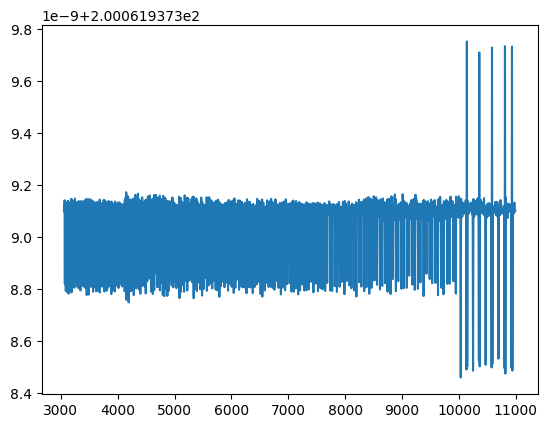

In [10]:
fig, ax = plt.subplots()
ax.plot(lls[:-1], res)

In [11]:
res

array([200.06193726, 200.06193726, 200.06193726, ..., 200.06193726,
       200.06193726, 200.06193726])

# Read spectra

In [12]:
df = pd.read_csv("./SN2006dv.dat_FLWO-1.5m_FAST_CfA-Ia.flm.csv")
df["log10lambda"] = np.log10(df["lambda"])
df["log10lambda_idx"] = df["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days')) # fool pandas to make it think log10lambda is days
df.set_index("log10lambda_idx", inplace=True)
df

,Unnamed: 0,mjd,lambda,flux_lambda,e_flux_lambda,instrument,log10lambda
log10lambda_idx,,,,,,,
3 days 12:59:20.085275037,3526,53941.43,3477.00,1.781679e-16,1.139438e-16,FLWO-1.5m_FAST_CfA-Ia.flm,3.541205
3 days 12:59:35.945849336,3527,53941.43,3478.47,2.250749e-16,1.136162e-16,FLWO-1.5m_FAST_CfA-Ia.flm,3.541388
3 days 12:59:51.799722383,3528,53941.43,3479.94,1.900315e-16,1.112404e-16,FLWO-1.5m_FAST_CfA-Ia.flm,3.541572
3 days 13:00:07.646899835,3529,53941.43,3481.41,1.096250e-16,1.118726e-16,FLWO-1.5m_FAST_CfA-Ia.flm,3.541755
3 days 13:00:23.487387344,3530,53941.43,3482.88,1.247406e-16,1.166179e-16,FLWO-1.5m_FAST_CfA-Ia.flm,3.541939
...,...,...,...,...,...,...,...
3 days 20:52:28.495098333,6201,53941.43,7409.25,7.488278e-17,9.497917e-18,FLWO-1.5m_FAST_CfA-Ia.flm,3.869774
3 days 20:52:35.938956005,6202,53941.43,7410.72,7.071148e-17,9.513734e-18,FLWO-1.5m_FAST_CfA-Ia.flm,3.869860
3 days 20:52:43.381337257,6203,53941.43,7412.19,6.224354e-17,9.450742e-18,FLWO-1.5m_FAST_CfA-Ia.flm,3.869947


Show wavelength resolution in km/s, note that it increases with wavelength 

In [13]:
# dlambda / lambda * c = dloglambda * c = dlog10lambda * log(10) * c
# note that since the index is log10lambda we need to get the values to subtract shifted vectors
res = np.abs(df.log10lambda[:-1].values - df.log10lambda[1:].values) * np.log(10) * cspeed
res

array([126.80667347, 126.75309634, 126.69956447, ...,  59.50248655,
        59.49068707,  59.47889227])

We will convolve the observed spectra with a kernel width equal to the loglambda grid resolution (200 km/s) and will use a 2000 km/s smoothing kernel to define a continuum.

In [14]:
dv = 200 # km/s # using values to show the effect
dvsmooth = 2000 # km/s

How many seconds would dlog10lambda correspond to? (remember we are fooling pandas)

In [15]:
dlog10lambda = dv / cspeed / np.log(10) * 24 * 3600 # pseudo seconds
dlog10lambda

25.015362157627305

And dlog10lambdasmooth? (remember we are fooling pandas)

In [16]:
dlog10lambdasmooth = dvsmooth / cspeed / np.log(10) * 24 * 3600 # pseudo seconds
dlog10lambdasmooth

250.15362157627305

Get km/s w.r.t. FeII. 

WARNING: this assumes that the spectra is in rest frame wavelength

In [17]:
FeII = 5169

In [18]:
df["vFeII"] = (df["lambda"] - FeII) / FeII * cspeed

Plot original and smoothed versions

Text(0.5, 0, '$\\lambda$ [A]')

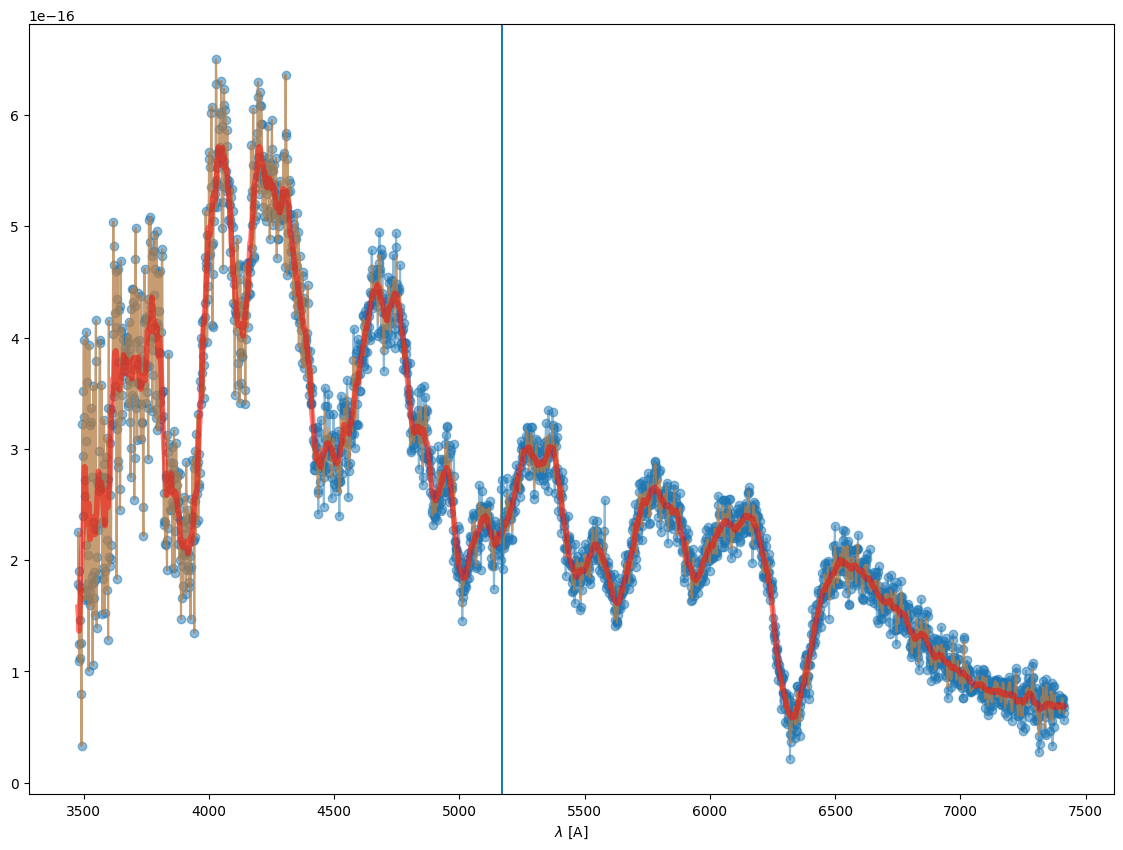

In [19]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(df["lambda"], df.flux_lambda, marker='o', alpha=0.5)
ax.plot(df["lambda"], df.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean(), alpha=0.5)
ax.plot(df["lambda"], df.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean(), c='r', lw=4, alpha=0.5)
ax.axvline(FeII)
ax.set_xlabel(r"$\lambda$ [A]")

Text(0.5, 0, 'v(Fe II) [km/s]')

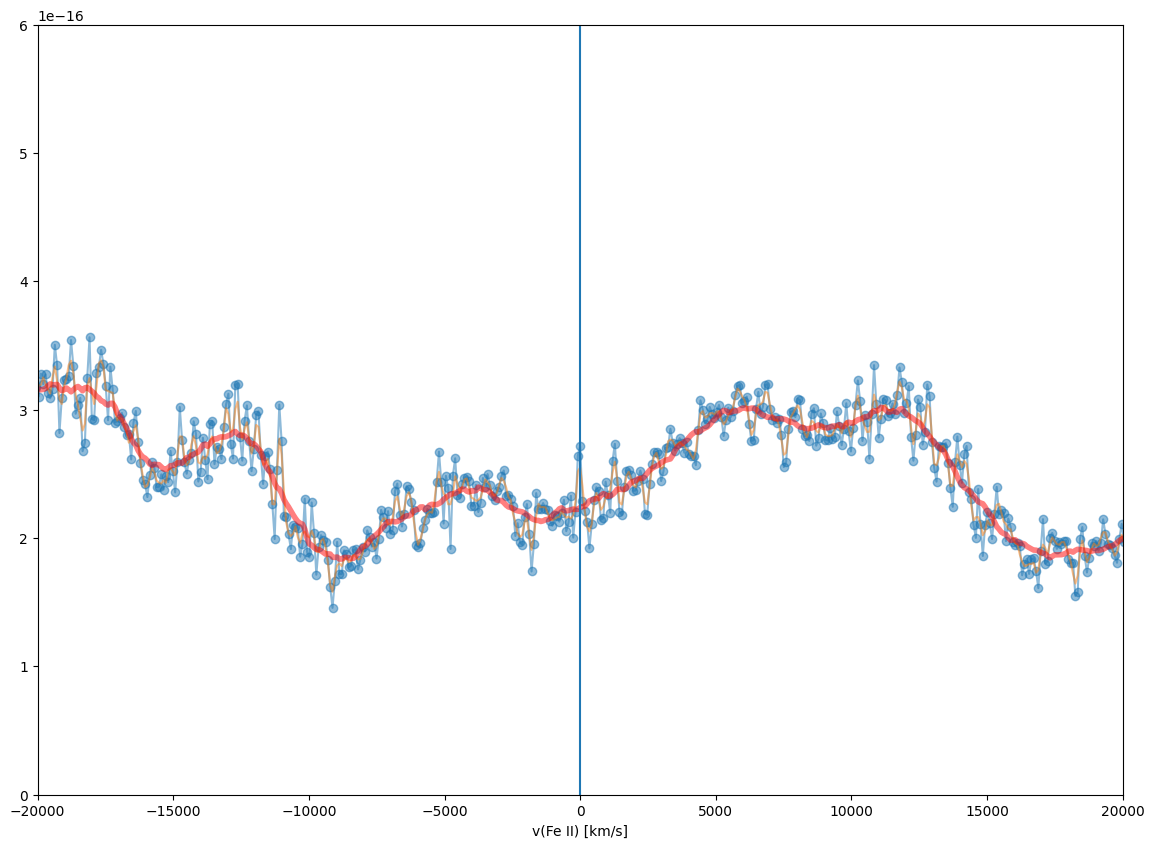

In [20]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(df.vFeII, df.flux_lambda, marker='o', alpha=0.5)
ax.plot(df.vFeII, df.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean(), alpha=0.5)
ax.plot(df.vFeII, df.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean(), c='r', lw=4, alpha=0.5)
ax.axvline(0)
ax.set_xlim(-20000, 20000)
ax.set_ylim(0, 6e-16)
ax.set_xlabel("v(Fe II) [km/s]")

Plot dispersion w.r.t. smoothed version (use as empirical error)

Text(0.5, 0, '$\\lambda$ [A]')

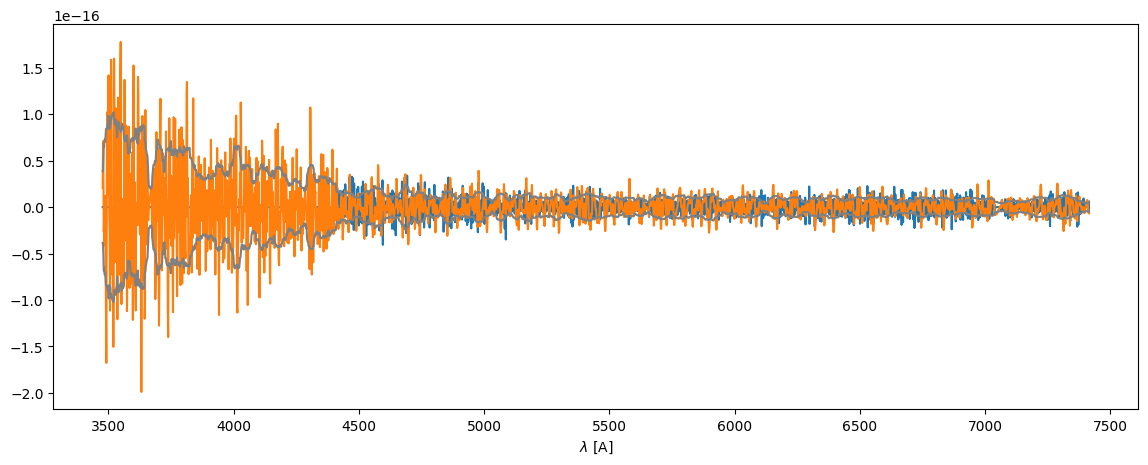

In [21]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df["lambda"], df.flux_lambda - df.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean())
ax.plot(df["lambda"], (df.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean() - df.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()))
delta = (df.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean() - df.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
ax.plot(df["lambda"], -delta, c='gray')
ax.plot(df["lambda"], delta, c='gray')
ax.set_xlabel(r"$\lambda$ [A]")